# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


**Import and set-up**

Import the library and toy data

In [2]:
import pyxpcm
from pyxpcm.models import pcm

# Load a dataset to work with:
ds = pyxpcm.tutorial.open_dataset('argo').load()

# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

## Debugging

Use option ``debug`` to print log messages 

In [3]:
# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds);

> Start preprocessing for action 'fit'

	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in the input axis, not need to interpolate, simple intersection
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))] X INTERPOLATED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X SCALED with success)
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None] X REDUCED with success)
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'
	 [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))] X RAVELED with success
		Output axis is in

## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings during execution

In [4]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=1)
m.fit(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 58 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 27 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 1 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 12 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 7 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 16 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 2 ms
  fit.1-preprocess.2-feature_temperature.total: 68 ms
  fit.1-preprocess: 68 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_salinity.1-ravel: 30 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 1 ms
  fit.1-preprocess.2-feature_salinity.3-scale_fit: 11 ms
  fit.1-preprocess.2-feature_salinity.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 14 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 4 ms
  fit.1-preprocess.2-feature_salinity.total: 68 ms
  fit.1-preprocess: 68 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-x

### A posteriori Execution time analysis

In [5]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=0)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [6]:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                  137.017250
                           2-feature_temperature  1-ravel                 34.789801
                                                  2-interp                 1.374245
                                                  3-scale_fit             12.953997
                                                  4-scale_transform        6.776094
                                                  5-reduce_fit            29.793739
                                                  6-reduce_transform       3.415108
                                                  total                   89.292049
                           total                                         448.949337
                           3-homogeniser          total                    2.951860
                           2-feature_salinity     1-ravel                 27.996778
       

## Visualisation help

### Main steps by method

Sub-method,1-preprocess,fit,predict,score,xarray
Method,,,,,
fit,896.322966,2926.816702,NaN,12.502909,NaN
fit_predict,381.493330,3101.674080,16.546011,19.073009,42.071819
predict,396.913052,NaN,9.721994,12.176752,10.524988


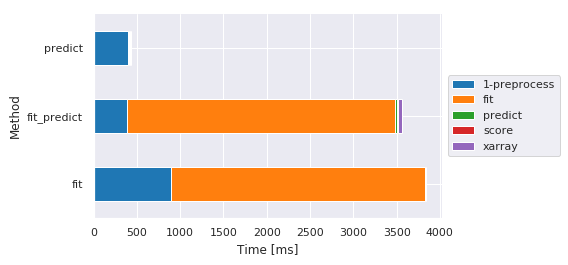

In [7]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Preprocessing main steps by method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,137.017250,127.899408,178.395033,2.951860,1.110077
fit_predict,42.536974,72.401047,72.146177,1.843929,1.113892
predict,48.269033,74.509859,73.057890,0.752211,1.103878


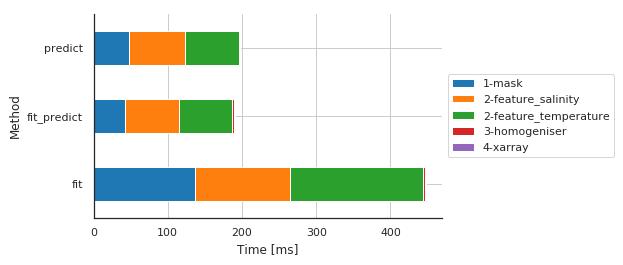

In [8]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Preprocessing details by method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,62.786579,3.127337,25.325060,12.425423,42.983770,6.323099
fit_predict,53.791046,2.363682,0.001907,10.478020,0.002623,5.509138
predict,54.409027,2.607822,0.001907,11.278152,0.003099,5.352974


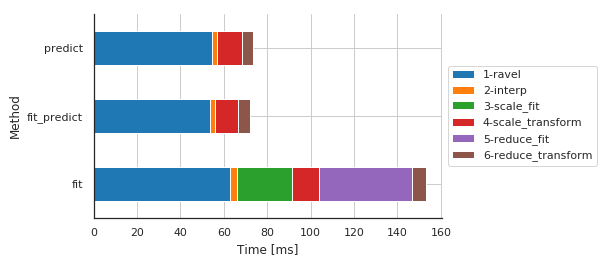

In [9]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Preprocessing details by features

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.083177,0.004353,0.012373,0.015879,0.013192,0.008219
2-feature_temperature,0.087810,0.003746,0.012956,0.018302,0.029798,0.008966


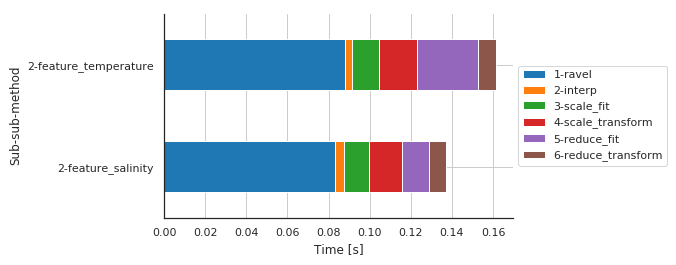

In [10]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df